In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd

In [2]:
import  os

import numpy as np
import pandas as pd


from create_df_larger import read_df_larger
df, dfc, all_homes, appliance_min, national_average = read_df_larger()

df = df.rename(columns={'house_num_rooms':'num_rooms',
                        'num_occupants':'total_occupants',
                        'difference_ratio_min_max':'ratio_difference_min_max'})
K_min, K_max = 1,6
F_min, F_max=1,8

from all_functions import *
from features_larger import *

In [3]:
appliance="mw"
if appliance=="hvac":
    start, end=5, 11
else:
    start, end = 1, 13

appliance_cols = ['%s_%d' %(appliance, month) for month in range(start, end)]
aggregate_cols = ['aggregate_%d' %month for month in range(start, end)]

all_cols = deepcopy(appliance_cols)
all_cols.extend(aggregate_cols)
X_matrix = dfc[all_cols].dropna()
    

In [4]:
columns_max = {}
columns_min = {}
col_max = X_matrix.max()
columns_max[appliance]=col_max
col_min = X_matrix.min()
columns_min[appliance]=col_min
X_normalised = X_matrix.copy()
#for col in X_matrix.columns:
#    X_normalised[col] = (X_matrix[col]-col_min[col])/(col_max[col]-col_min[col])
for col in X_matrix.columns:
    X_normalised[col] = (X_matrix[col]-col_min.min())/(col_max.max()-col_min.min())



In [5]:
pd.DataFrame(X_normalised).head()

,mw_1,mw_2,mw_3,mw_4,mw_5,mw_6,mw_7,mw_8,mw_9,mw_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
26,0.001632,0.001243,0.001310,0.001099,0.001100,0.001107,0.001217,0.001075,0.001047,0.001099,...,0.171898,0.226005,0.278204,0.401015,0.494946,0.547904,0.396213,0.347527,0.209708,0.188609
101,0.004135,0.002770,0.003508,0.003824,0.003317,0.002793,0.003595,0.003628,0.003259,0.004184,...,0.082587,0.132150,0.150965,0.201967,0.256303,0.235608,0.207589,0.144267,0.099998,0.097919
545,0.003723,0.002947,0.003052,0.003438,0.004158,0.004138,0.003969,0.003969,0.004065,0.003331,...,0.188018,0.263056,0.314090,0.486922,0.604185,0.633584,0.478677,0.326214,0.174713,0.178100
661,0.001229,0.000297,0.000463,0.000756,0.002132,0.001187,0.000523,0.000335,0.000700,0.000777,...,0.194631,0.223291,0.280392,0.437615,0.521850,0.578748,0.456683,0.348492,0.187601,0.232565
871,0.000825,0.000636,0.000677,0.000411,0.000558,0.000458,0.000667,0.000558,0.000602,0.000662,...,0.173112,0.149647,0.165490,0.216474,0.270888,0.316635,0.244643,0.175815,0.140707,0.184419


In [6]:
df = pd.DataFrame(X_normalised)

In [7]:
df.head()

,mw_1,mw_2,mw_3,mw_4,mw_5,mw_6,mw_7,mw_8,mw_9,mw_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
26,0.001632,0.001243,0.001310,0.001099,0.001100,0.001107,0.001217,0.001075,0.001047,0.001099,...,0.171898,0.226005,0.278204,0.401015,0.494946,0.547904,0.396213,0.347527,0.209708,0.188609
101,0.004135,0.002770,0.003508,0.003824,0.003317,0.002793,0.003595,0.003628,0.003259,0.004184,...,0.082587,0.132150,0.150965,0.201967,0.256303,0.235608,0.207589,0.144267,0.099998,0.097919
545,0.003723,0.002947,0.003052,0.003438,0.004158,0.004138,0.003969,0.003969,0.004065,0.003331,...,0.188018,0.263056,0.314090,0.486922,0.604185,0.633584,0.478677,0.326214,0.174713,0.178100
661,0.001229,0.000297,0.000463,0.000756,0.002132,0.001187,0.000523,0.000335,0.000700,0.000777,...,0.194631,0.223291,0.280392,0.437615,0.521850,0.578748,0.456683,0.348492,0.187601,0.232565
871,0.000825,0.000636,0.000677,0.000411,0.000558,0.000458,0.000667,0.000558,0.000602,0.000662,...,0.173112,0.149647,0.165490,0.216474,0.270888,0.316635,0.244643,0.175815,0.140707,0.184419


In [8]:
def transform_2(pred_df,appliance,  col_max, col_min):
    pred_df_copy = pred_df.copy()
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    
    for month in range(start, stop):
        pred_df_copy['%s_%d' %(appliance,month)] = (col_max.max()-col_min.min())*pred_df['%s_%d'%(appliance,month)] +col_min.min()
    return pred_df_copy

def transform(pred_df,appliance,  col_max, col_min):
    pred_df_copy = pred_df.copy()
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    
    for month in range(start, stop):
        pred_df_copy['%s_%d' %(appliance,month)] = (col_max['%s_%d' %(appliance, month)]-col_min['%s_%d' %(appliance,month)])*pred_df['%s_%d'%(appliance,month)] +col_min['%s_%d' %(appliance,month)]
    return pred_df_copy



In [12]:
k=3
np.random.seed(0)

# Generate random data matrix A.
m = len(A)
n = len(A.columns)


# Initialize Y randomly.
Y_init = np.random.rand(m, k)

# Ensure same initial random Y, rather than generate new one
# when executing this cell.
Y = Y_init
Y[:,:np.shape(occ)[1]]=occ

In [13]:
Y

array([[ 0.8       ,  0.71518937,  0.60276338],
       [ 0.6       ,  0.4236548 ,  0.64589411],
       [ 0.4       ,  0.891773  ,  0.96366276],
       [ 0.4       ,  0.79172504,  0.52889492],
       [ 0.8       ,  0.92559664,  0.07103606],
       [ 0.2       ,  0.0202184 ,  0.83261985],
       [ 0.4       ,  0.87001215,  0.97861834],
       [ 0.2       ,  0.46147936,  0.78052918],
       [ 0.6       ,  0.63992102,  0.14335329],
       [ 0.2       ,  0.52184832,  0.41466194],
       [ 0.4       ,  0.77423369,  0.45615033],
       [ 0.6       ,  0.0187898 ,  0.6176355 ],
       [ 0.4       ,  0.616934  ,  0.94374808],
       [ 0.8       ,  0.3595079 ,  0.43703195],
       [ 0.4       ,  0.06022547,  0.66676672],
       [ 0.8       ,  0.21038256,  0.1289263 ],
       [ 0.4       ,  0.36371077,  0.57019677],
       [ 0.4       ,  0.98837384,  0.10204481],
       [ 0.4       ,  0.16130952,  0.65310833],
       [ 0.6       ,  0.46631077,  0.24442559],
       [ 0.6       ,  0.11037514,  0.656

In [15]:
#residual = np.zeros(MAX_ITERS)
X = cvx.Variable(k, n)
constraint = [X >= 0]
Temp = Y*X

# Solve the problem.
obj = cvx.Minimize(cvx.norm(A.values[mask] - (Y*X)[mask], 'fro'))
prob = cvx.Problem(obj, constraint)
prob.solve(solver=cvx.SCS)

3.2177728915116153

In [18]:
X=X.value

In [29]:
Y0 = cvx.Variable(m,1)
Y0.value = occ
Y1 = cvx.Variable(m, k-1)


In [31]:
Y0.value

matrix([[ 0.8],
        [ 0.6],
        [ 0.4],
        [ 0.4],
        [ 0.8],
        [ 0.2],
        [ 0.4],
        [ 0.2],
        [ 0.6],
        [ 0.2],
        [ 0.4],
        [ 0.6],
        [ 0.4],
        [ 0.8],
        [ 0.4],
        [ 0.8],
        [ 0.4],
        [ 0.4],
        [ 0.4],
        [ 0.6],
        [ 0.6],
        [ 0.4],
        [ 0.2],
        [ 0.2],
        [ 0.4],
        [ 0.4],
        [ 0.4],
        [ 0.6],
        [ 0.6],
        [ 0.4],
        [ 0.6],
        [ 0.4],
        [ 0.8],
        [ 1. ],
        [ 0.4],
        [ 0.2],
        [ 1. ],
        [ 0.4],
        [ 0.4],
        [ 0.8],
        [ 0.8],
        [ 0.4],
        [ 0.6],
        [ 0.8],
        [ 0.6],
        [ 1. ],
        [ 0.2],
        [ 0.8]])

In [ ]:
# Perform alternating minimization.

residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cvx.Variable(k, n)
        constraint = [X >= 0]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cvx.Variable(m, k)

        constraint = [Y >= 0, Y[:,:np.shape(f)[1]]==f]

        #Y.value[0]=f
    Temp = Y*X

    # Solve the problem.
    obj = cvx.Minimize(cvx.norm(A.values[mask] - (Y*X)[mask], 'fro'))
    prob = cvx.Problem(obj, constraint)
    prob.solve(solver=cvx.SCS)

    if prob.status != cvx.OPTIMAL:
        pass
        #return X.value, Y.value, residual
        #raise Exception("Solver did not converge!")

    #print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value
return X, Y, residual

In [352]:
def nmf_features(A, k, f, MAX_ITERS=30):
    np.random.seed(0)

    # Generate random data matrix A.
    m = len(A)
    n = len(A.columns)
    
    
    # Initialize Y randomly.
    Y_init = np.random.rand(m, k)

    # Ensure same initial random Y, rather than generate new one
    # when executing this cell.
    Y = Y_init
    #Y[0] = f

    # Perform alternating minimization.
    
    residual = np.zeros(MAX_ITERS)
    for iter_num in range(1, 1+MAX_ITERS):
        # At the beginning of an iteration, X and Y are NumPy
        # array types, NOT CVXPY variables.

        # For odd iterations, treat Y constant, optimize over X.
        if iter_num % 2 == 1:
            X = cvx.Variable(k, n)
            constraint = [X >= 0]
        # For even iterations, treat X constant, optimize over Y.
        else:
            Y = cvx.Variable(m, k)
            
            constraint = [Y >= 0, Y[:,:np.shape(f)[1]]==f]
            
            #Y.value[0]=f
        Temp = Y*X

        # Solve the problem.
        obj = cvx.Minimize(cvx.norm(A.values[mask] - (Y*X)[mask], 'fro'))
        prob = cvx.Problem(obj, constraint)
        prob.solve(solver=cvx.SCS)

        if prob.status != cvx.OPTIMAL:
            pass
            #return X.value, Y.value, residual
            #raise Exception("Solver did not converge!")

        #print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
        residual[iter_num-1] = prob.value

        # Convert variable to NumPy array constant for next iteration.
        if iter_num % 2 == 1:
            X = X.value
        else:
            Y = Y.value
    return X, Y, residual

In [9]:
area = dfc.ix[X_normalised.index].area.div(dfc.ix[X_normalised.index].area.max()).reshape((len(X_normalised),1))
occ = dfc.ix[X_normalised.index].num_occupants.div(dfc.ix[X_normalised.index].num_occupants.max()).reshape((len(X_normalised),1))
rooms = dfc.ix[X_normalised.index].house_num_rooms.div(dfc.ix[X_normalised.index].house_num_rooms.max()).reshape((len(X_normalised),1))

out = {}
for lat in range(1, 10):
    out[lat]={}
    print lat
    for home in X_normalised.index[:1]:
        
        X_home = X_normalised.copy()
        for month in range(start, end):
            X_home.loc[home, '%s_%d' %(appliance, month)] = np.NAN
        mask = X_home.notnull().values
        # Ensure repeatably random problem data.
        A = X_home.copy()
        X, Y, res = nmf_features(A, lat,occ, 10)
        
        pred_df = pd.DataFrame(Y*X)
        pred_df.columns = X_normalised.columns
        pred_df.index = X_normalised.index
        #out[lat][home] = pred_df.ix[home][appliance_cols]
        out[lat][home] = transform_2(pred_df.ix[home], appliance, col_max, col_min)[appliance_cols]


1


NameError: name 'nmf_features' is not defined

In [358]:

error_lat = {}
gt = X_matrix[appliance_cols]
for lat in range(1,10):
    
    pr = pd.DataFrame(out[lat]).T
    
    error = (pr-gt).abs()
    error_lat[lat] = error.div(gt).mul(100).median().mean()
pd.Series(error_lat)

1    49.362503
2    44.541212
3    45.400123
4    45.474315
5    46.244208
6    47.786196
7    50.392540
8    51.471266
9    46.366141
dtype: float64

In [288]:
pr.head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,196.091541,510.438427,725.603175,797.618660,571.634903,329.962991
59,300.574377,439.607694,736.647472,872.121906,564.484110,292.094224
94,59.675339,112.087022,204.522310,245.872365,164.533801,79.063395
101,145.014634,284.429481,447.465995,412.784591,332.739350,160.727158
222,280.559744,687.019495,1242.105584,1969.087197,949.320152,666.643006


In [289]:
gt.head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,242.395737,543.781433,761.394043,902.418823,610.035828,395.169098
59,77.613205,197.951508,457.950378,700.443054,244.340973,81.064682
94,19.836948,66.621819,126.121681,155.045364,92.979385,33.392750
101,191.965454,325.858032,462.708923,485.186005,350.491455,192.567566
222,478.951691,896.467285,1077.890137,1139.740479,887.044739,584.328979


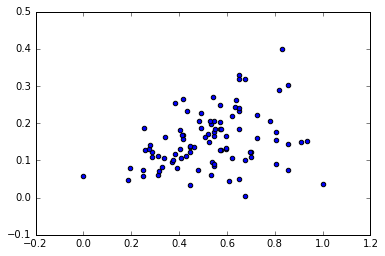

In [286]:
plt.scatter(area,pd.DataFrame(A[['hvac_8']].values))

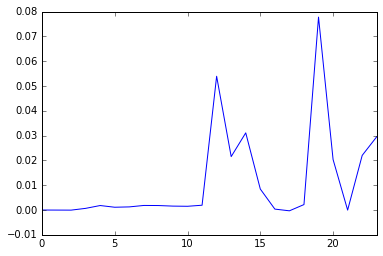

In [200]:
pd.DataFrame(X).ix[2].plot()

In [130]:
pd.DataFrame(Y)

,0,1,2
0,0.531686,1.147314,0.241875
1,0.935053,-0.000059,1.284663
2,0.444738,0.252777,-0.000245
3,0.337671,0.565742,0.051033
4,0.571416,1.961088,1.764757
5,0.635062,1.443250,0.111107
6,0.545451,0.250699,0.218164
7,0.432192,1.226744,0.344101
8,0.429090,0.435043,0.330675
9,0.524793,0.620378,-0.001384


In [82]:
vari = {}
for home in X_normalised.index:
    vari[home] = (dfc.ix[home][aggregate_cols].max()-dfc.ix[home][aggregate_cols].min())
    
varia = {}
for home in X_normalised.index:
    varia[home] = dfc.ix[home][aggregate_cols].std()

max_agg = {}
for home in X_normalised.index:
    max_agg[home] = dfc.ix[home][aggregate_cols].max()

In [119]:
np.corrcoef(pd.DataFrame(Y)[0],pd.Series(varia))

array([[ 1.        ,  0.58240215],
       [ 0.58240215,  1.        ]])

In [84]:
np.corrcoef(pd.Series(max_agg),pd.Series(vari))

array([[ 1.        ,  0.95214449],
       [ 0.95214449,  1.        ]])

In [85]:
plt.scatter(pd.DataFrame(Y)[1], pd.Series(varia))
plt.ylabel("Variance of aggregate monthly energy\n (across 12 months)")
plt.xlabel("Latent factor for home")

NameError: name 'plt' is not defined

In [86]:
plt.scatter(pd.DataFrame(Y)[0], X_matrix['aggregate_12'])

NameError: name 'plt' is not defined

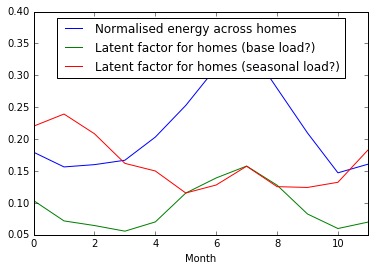

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.figure(figsize=(8,6))
pd.DataFrame(A)[aggregate_cols].mean().plot(label="Normalised energy across homes")
e = pd.DataFrame(X)
e.columns=X_matrix.columns
e[aggregate_cols].ix[0].plot(label="Latent factor for homes (base load?)")
e[aggregate_cols].ix[2].plot(label="Latent factor for homes (seasonal load?)")

plt.gca().set_xticklabels(range(0, 12,2))
plt.xlabel("Month")
plt.legend(loc=9)


In [88]:
%matplotlib inline

In [89]:
pd.DataFrame([pd.DataFrame(Y)[1].values, pd.DataFrame(A)['mw_7'].values]).T.corr()

KeyError: 'mw_7'

In [90]:
pd.DataFrame(Y)[0].describe()

count    69.000000
mean      0.999910
std       0.000459
min       0.997639
25%       1.000009
50%       1.000016
75%       1.000030
max       1.000146
Name: 0, dtype: float64

In [91]:
pd.DataFrame(Y).corr()

,0,1,2
0,1.000000,0.283993,0.193161
1,0.283993,1.000000,0.400156
2,0.193161,0.400156,1.000000


In [92]:
corrs = [pd.DataFrame(Y)[i].corr(pd.Series(dfc.ix[X_matrix.index].num_occupants.values)) for i in range(4)]

KeyError: 3

In [93]:
pd.Series(corrs).plot(kind='bar',rot=0)
plt.xlabel("Latent factor #")
plt.ylabel("Correlation with area")
plt.title("Appliance=%s" %appliance)

NameError: name 'corrs' is not defined

In [94]:
pd.DataFrame(Y)[4].corr(pd.Series(dfc.ix[X_matrix.index].area.values))

KeyError: 4

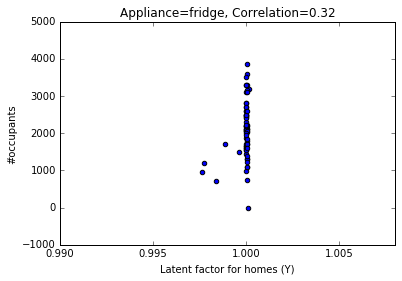

In [95]:
co = pd.DataFrame(Y)[0].corr(pd.Series(dfc.ix[X_matrix.index].area.values))
plt.scatter(pd.DataFrame(Y)[0], dfc.ix[X_matrix.index].area)
plt.xlabel("Latent factor for homes (Y)")
plt.ylabel("#occupants")
plt.title("Appliance=%s, Correlation=%0.2f" %(appliance, co))

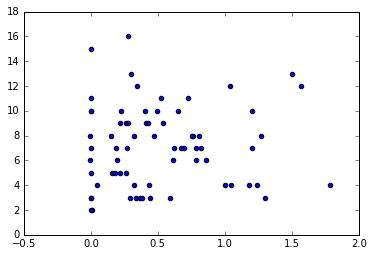

In [96]:
plt.scatter(pd.DataFrame(Y)[1], dfc.ix[X_matrix.index].house_num_rooms)

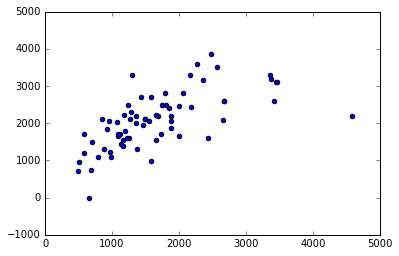

In [97]:
plt.scatter(pd.Series(max_agg), dfc.ix[X_matrix.index].area)

In [98]:
import matplotlib.pyplot as plt
plt.scatter(pd.DataFrame(Y)[1], pd.DataFrame(A)['mw_1'])
plt.xlabel("Latent factor for home")
plt.ylabel("WM energy consumption")
#plt.ylim((0,0.004))

KeyError: 'mw_1'

In [99]:
X_m = pd.DataFrame(X)
X_m.columns = A.columns

ValueError: x and y must be the same size

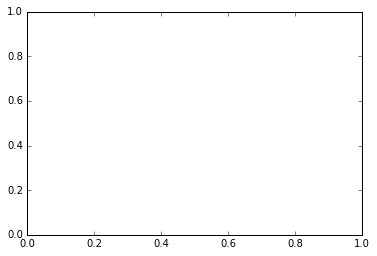

In [100]:
plt.scatter(X_m.values.flatten()[12:],X_m.values.flatten()[:12])

In [101]:
dds = [438, 579, 724, 747, 617, 376]

In [102]:
X_m.values.flatten()[:6]

array([ 0.00827676,  0.00824801,  0.00981048,  0.00880445,  0.00866306,
        0.00919195])

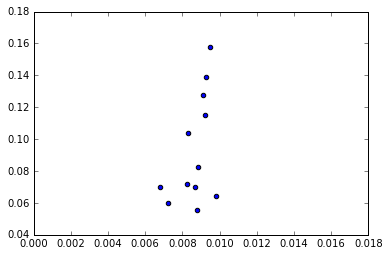

In [103]:
plt.scatter(X_m.ix[0].values[:12],X_m.ix[0].values[12:])

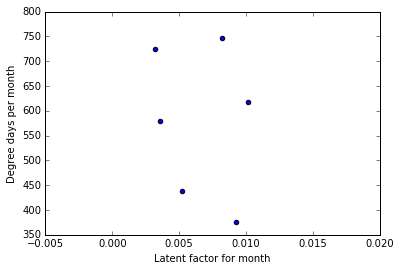

In [104]:
plt.scatter(X_m.ix[1].values.flatten()[:6], dds)
plt.xlabel("Latent factor for month")
plt.ylabel("Degree days per month")

In [105]:
pd.DataFrame(Y).corrwith(pd.DataFrame(A)['hvac_10'])

KeyError: 'hvac_10'

In [117]:
error_lat

{1: 28.16533888345263}

In [53]:
pd.DataFrame(out[1]).T.head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,245.072444,468.099853,719.521842,780.840442,558.748129,282.693567
59,213.142529,407.232402,623.663812,675.819377,485.543535,247.101512
94,75.897705,143.707019,219.694360,238.534062,171.053473,87.703643
101,119.326641,227.375958,348.506622,378.596035,271.048929,138.213791
222,534.515723,1026.999975,1595.523641,1735.603353,1235.946874,618.391287


In [54]:
A.head()[appliance_cols]

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,0.052413,0.118235,0.165761,0.196560,0.132704,0.085778
59,0.016425,0.042707,0.099490,0.152449,0.052838,0.017179
94,0.003807,0.014025,0.027019,0.033336,0.019781,0.006768
101,0.041399,0.070641,0.100529,0.105438,0.076021,0.041531
222,0.104076,0.195260,0.234882,0.248390,0.193202,0.127090


In [15]:
pd.Series(error_lat)

1    32.570682
dtype: float64

In [380]:
pd.DataFrame(Y).describe()

,0
count,95.000000
mean,0.660303
std,0.342348
min,0.117898
25%,0.423632
50%,0.614642
75%,0.827686
max,1.971936


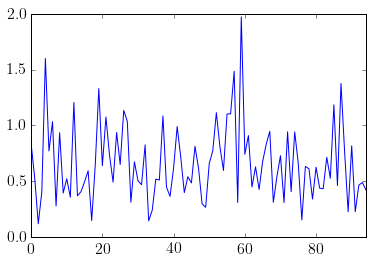

In [381]:
pd.DataFrame(Y).plot(legend=False)

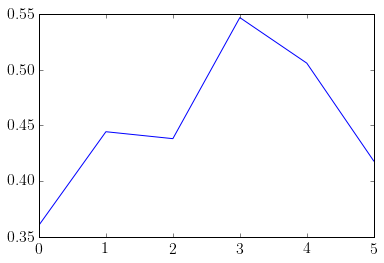

In [382]:
pd.DataFrame(X)[[0,1,2,3,4,5]].T.plot(legend=False)

In [363]:
pd.DataFrame(Y*X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.301025,0.370936,0.365748,0.456318,0.422244,0.349034,0.321586,0.447455,0.481452,0.346902,0.369798,0.324113
1,0.191067,0.235441,0.232148,0.289636,0.268008,0.221539,0.204118,0.284010,0.305589,0.220187,0.234719,0.205722
2,0.042508,0.052380,0.051648,0.064437,0.059626,0.049288,0.045412,0.063186,0.067987,0.048987,0.052220,0.045769
3,0.145898,0.179781,0.177267,0.221164,0.204649,0.169166,0.155863,0.216868,0.233345,0.168133,0.179230,0.157088
4,0.576494,0.710382,0.700446,0.873898,0.808642,0.668436,0.615872,0.856924,0.922033,0.664354,0.708202,0.620711
5,0.277854,0.342384,0.337596,0.421195,0.389743,0.322168,0.296833,0.413013,0.444394,0.320200,0.341333,0.299166
6,0.372349,0.458825,0.452408,0.564438,0.522290,0.431733,0.397783,0.553474,0.595527,0.429097,0.457417,0.400908
7,0.099863,0.123055,0.121334,0.151380,0.140076,0.115789,0.106684,0.148440,0.159718,0.115082,0.122678,0.107522
8,0.336755,0.414965,0.409161,0.510482,0.472362,0.390463,0.359758,0.500566,0.538599,0.388078,0.413691,0.362584
9,0.141821,0.174758,0.172314,0.214984,0.198931,0.164439,0.151508,0.210808,0.226825,0.163435,0.174222,0.152699


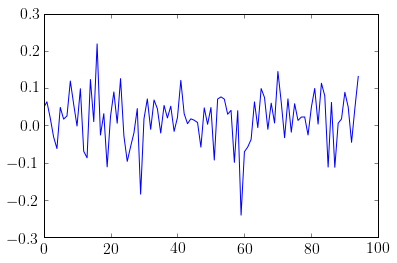

In [348]:
plt.plot(pd.DataFrame(Y*X)[0]-pd.DataFrame(X_normalised['hvac_5'].values)[0].values)

In [349]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y*X, X_normalised.values))
#pd.DataFrame(Y*X)-pd.DataFrame(X_normalised.values).

0.061689182092503847

In [289]:
pd.DataFrame(results).min()

dw        68.495285
fridge    41.210222
hvac      23.297621
mw        60.897398
oven      63.322534
wm        47.359437
dtype: float64

In [38]:
m = len(A)
n = len(A.columns)
k=3
Y_init = A.max().max()*np.random.rand(m, k)
pd.DataFrame(Y_init).describe()

,0,1,2
count,95.000000,95.000000,95.000000
mean,2298.792724,2590.036973,2493.324328
std,1366.027314,1337.211355,1312.536172
min,74.457818,1.682887,90.212011
25%,1070.234162,1441.592814,1509.352575
50%,2262.878502,2754.591065,2543.472756
75%,3528.501643,3792.788742,3639.383733
max,4573.696706,4574.483307,4572.175328


In [39]:
A.describe()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,204.697577,410.772775,634.932650,703.427444,496.814433,243.957545,894.636166,1117.168094,1435.362421,1570.281882,1260.032510,935.727852
std,152.308577,249.724508,348.390233,343.614402,252.160506,152.017218,526.052474,563.679895,699.529397,762.214791,607.968624,515.139351
min,3.054133,2.404883,9.934549,21.709467,40.952965,8.885633,182.287521,41.541668,174.545334,485.617706,386.186584,178.216537
25%,84.733067,239.801712,409.715370,469.171234,319.873489,144.406563,538.820801,741.668213,927.531219,1050.480408,845.363953,612.034912
50%,177.884102,338.474533,572.622009,643.759674,460.979889,214.063858,781.487122,979.500122,1289.663940,1425.989990,1142.088135,801.091187
75%,289.427666,542.997314,804.441116,892.596329,617.534866,346.822327,1093.304993,1403.773315,1764.296936,1903.711792,1561.776794,1104.915527
max,894.190308,1385.010742,2130.617920,1834.047852,1386.018921,876.380493,3120.817871,3010.485352,3481.583496,4581.233398,3462.281494,3176.753418


In [54]:
prob.status

'optimal'

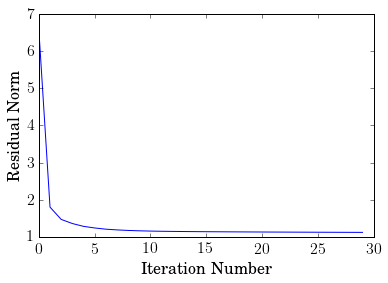

Original matrix:
        hvac_5    hvac_6    hvac_7    hvac_8    hvac_9   hvac_10  aggregate_5  \
26         NaN       NaN       NaN       NaN       NaN       NaN     0.264163   
59    0.083667  0.141433  0.211260  0.374507  0.151210  0.083204     0.314919   
94    0.018833  0.046446  0.054788  0.073571  0.038679  0.028250     0.043213   
101   0.211989  0.233945  0.213504  0.255734  0.230129  0.211738     0.114979   
222   0.534035  0.646650  0.503590  0.616900  0.629034  0.663339     0.790309   
364   0.262441  0.385219  0.342594  0.457073  0.447491  0.426416     0.245914   
545   0.389795  0.561114  0.497692  0.606508  0.555478  0.422386     0.306238   
624   0.078196  0.136574  0.140541  0.202991  0.147672  0.015232     0.098029   
661   0.245238  0.467515  0.439553  0.578096  0.531963  0.450393     0.266728   
871   0.090979  0.165842  0.185541  0.272096  0.207023  0.152141     0.132008   
946   0.240927  0.321466  0.280712  0.364962  0.305803  0.276486     0.123545   
1169  0.020

In [55]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Set plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Create the plot.
plt.plot(residual)
plt.xlabel('Iteration Number')
plt.ylabel('Residual Norm')
plt.show()

#
# Print results.
#
print 'Original matrix:'
print A
print 'Left factor Y:'
print Y
print 'Right factor X:'
print X
print 'Residual A - Y * X:'
print A - Y * X
print 'Residual after {} iterations: {}'.format(iter_num, prob.value)

In [58]:
pred_df = pd.DataFrame(Y*X)
pred_df.columns = X_normalised.columns
pred_df.index = X_normalised.index

In [60]:
pred_df.ix[26]

hvac_5          0.252252
hvac_6          0.386934
hvac_7          0.359241
hvac_8          0.504510
hvac_9          0.455555
hvac_10         0.360484
aggregate_5     0.273486
aggregate_6     0.462036
aggregate_7     0.448455
aggregate_8     0.335150
aggregate_9     0.348154
aggregate_10    0.310952
Name: 26, dtype: float64

In [61]:
X_normalised.ix[26]

hvac_5          0.268580
hvac_6          0.391562
hvac_7          0.354348
hvac_8          0.485952
hvac_9          0.423089
hvac_10         0.445286
aggregate_5     0.264163
aggregate_6     0.451381
aggregate_7     0.462876
aggregate_8     0.342351
aggregate_9     0.318240
aggregate_10    0.339887
Name: 26, dtype: float64

In [72]:
X_matrix.ix[26]

hvac_5           242.395737
hvac_6           543.781433
hvac_7           761.394043
hvac_8           902.418823
hvac_9           610.035828
hvac_10          395.169098
aggregate_5      958.539734
aggregate_6     1381.666504
aggregate_7     1705.293091
aggregate_8     1887.754883
aggregate_9     1365.123535
aggregate_10    1197.380859
Name: 26, dtype: float64